In [2]:
from ultralytics import YOLO
import cv2
model = YOLO("best.pt") 
import matplotlib.pyplot as plt
%matplotlib inline


image 1/1 C:\DeepLearning\JupyterWorkspace\ \car_2.jpg: 640x480 1 licence, 215.9ms
Speed: 6.8ms preprocess, 215.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict6
<class 'numpy.ndarray'>
Class: licence, Box: [1388 2136 2268 2311]


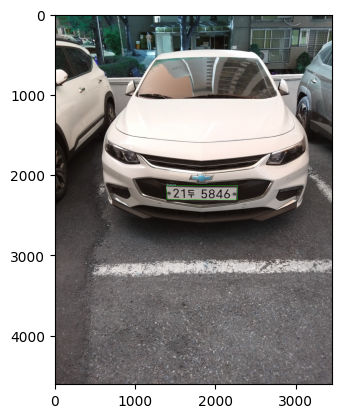

In [5]:
results = model.predict('car_2.jpg', save=True, conf=0.5)
img = cv2.imread('car_2.jpg')
#results = model.predict('1.jpg', save=True, conf=0.5)
#img = cv2.imread('1.jpg')
img_crop = None
color1 = (155, 200, 230)
for result in results:
    boxes = result.boxes.cpu().numpy()  # Get boxes on CPU in numpy format
    for box in boxes:  # Iterate over boxes
        print(type(box.xyxy[0]))
        r = box.xyxy[0].astype(int)  # Get corner points as int
        class_id = int(box.cls[0])  # Get class ID
        class_name = model.names[class_id]  # Get class name using the class ID
        print(f"Class: {class_name}, Box: {r}")  # Print class name and box coordinates
        cv2.rectangle(img, r[:2], r[2:], (0, 255, 0), 2)  # Draw boxes on the image
        cv2.putText(img, class_name, (r[0], r[1]), 1, 2, color1, 2, cv2.LINE_AA)
        img_crop = img[r[:2], r[2:]]

plt.imshow(img)
plt.show()

[{'contour': array([[[674,  53]],

        [[675,  52]],

        [[677,  52]],

        [[679,  54]],

        [[679,  76]],

        [[678,  77]],

        [[678, 106]],

        [[677, 107]],

        [[677, 123]],

        [[678, 124]],

        [[678, 126]],

        [[681, 129]],

        [[682, 129]],

        [[683, 130]],

        [[686, 130]],

        [[687, 131]],

        [[688, 131]],

        [[689, 132]],

        [[688, 133]],

        [[684, 133]],

        [[683, 134]],

        [[681, 134]],

        [[679, 136]],

        [[678, 136]],

        [[678, 137]],

        [[677, 138]],

        [[677, 139]],

        [[676, 140]],

        [[676, 151]],

        [[673, 154]],

        [[672, 154]],

        [[671, 153]],

        [[671, 151]],

        [[670, 150]],

        [[671, 149]],

        [[671, 139]],

        [[669, 137]],

        [[669, 136]],

        [[667, 134]],

        [[665, 134]],

        [[664, 133]],

        [[662, 133]],

        [[661, 132]],


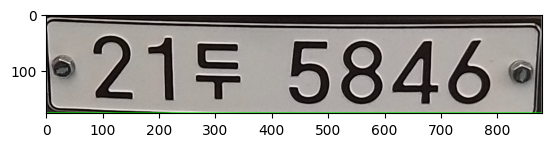

In [24]:
for result in results:
    boxes = result.boxes.cpu().numpy()  # Get boxes on CPU in numpy format
    for box in boxes:
        print(r)

plt.imshow(img_crop)

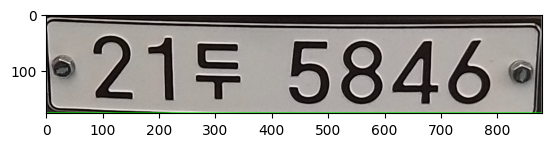

True

In [19]:
# [399 253 603 353]
#img_crop = img[253:353,399:603].copy()
#img_crop =  img[1024:1196, 718:1605]
img_crop =  img[2136:2311, 1388:2268]
height, width, channel = img_crop.shape
plt.imshow(img_crop)
plt.show()
cv2.imwrite('xx.jpg', img_crop)

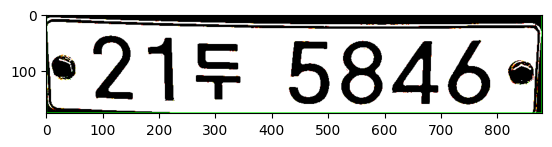

In [7]:
ret, thr = cv2.threshold(img_crop, 128, 255, cv2.THRESH_BINARY)
plt.imshow(thr)
height, width, channel = img_crop.shape

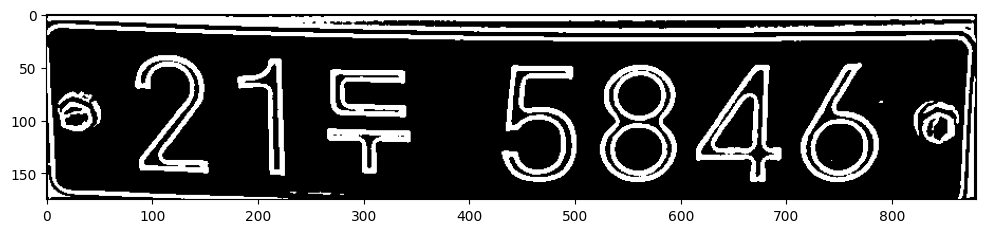

In [8]:
gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

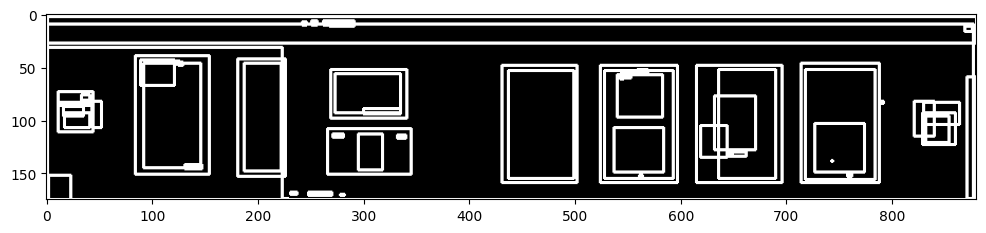

In [9]:
import numpy as np
contours, _= cv2.findContours(img_thresh,mode=cv2.RETR_TREE,
                              method=cv2.CHAIN_APPROX_SIMPLE)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, 
                 color=(255, 255, 255))

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), 
                  color=(255, 255, 255), thickness=2)
    
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

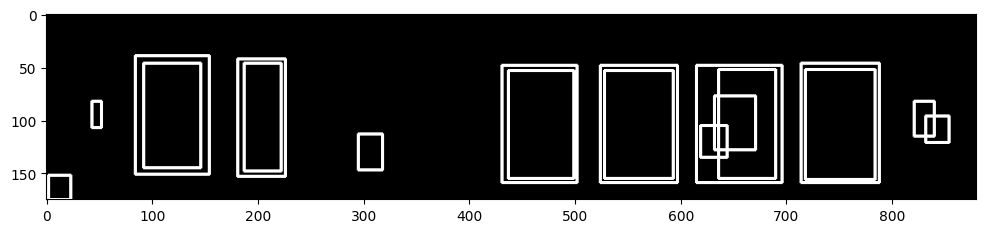

In [10]:
MIN_AREA = 80   # 번호판 윤곽선 최소 범위 지정
MIN_WIDTH, MIN_HEIGHT = 2, 8         # 최소 너비 높이 범위 지정
MIN_RATIO, MAX_RATIO = 0.25, 1.0     # 최소 비율 범위 지정

possible_contours = []  # possible_contours에 저장

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    
  # 위에 설정한 범위의 조건을 비교, 맞추면서 다시한번 possible_contours에 저장해준다. 
  # 각 윤곽선의 idx값을 매겨놓고, 나중에 조건에 맞는 윤곽선들의 idx만 따로 빼낼 것이다.  d['idx'] = cnt
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
# possible contours의 정렬방식을 보고 번호판 후보들을 추려낸다. 번호판은 어느정도 규칙적으로 일렬로 나타난다. 순차적,각도,배열모양..
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

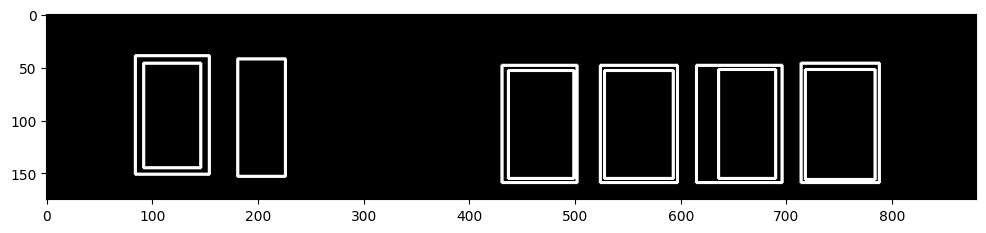

In [11]:
MAX_DIAG_MULTIPLYER = 5 # 5  대각선길이
MAX_ANGLE_DIFF = 12.0 # 12.0  1번째 contour와 2번째 contour 의 각도
MAX_AREA_DIFF = 0.5 # 0.5  면적의 차이
MAX_WIDTH_DIFF = 0.8 # 너비 차이
MAX_HEIGHT_DIFF = 0.2 # 높이 차이
MIN_N_MATCHED = 3 # 3 # 위에 조건들이 3개이상 충족해야 번호판이다

# find_chars 함수로 지정한다. 나중에 재귀함수로 반복해서 찾기 위함이다. idx값 저장

def find_chars(contour_list):
    matched_result_idx = []
    
    
# 이중for문으로 예를들면 첫번째 contour와 두번째 contour를 비교

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            
# np.linalg.norm(a - b) 벡터 a와 벡터 b 사이의 거리를 구한다.
# 삼각함수 사용
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) #면적의 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이의 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        # 번호판 후보군의 윤곽선 개수가 3보다 작으면 번호판일 확률이 낮다. 이유는 한국 번호판은 총 7자리 이기 때문이다.
        matched_contours_idx.append(d1['idx'])
        # 육관선 개수가 3보다 작을때는 continue를 통해 제외
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
        # 최종 호부군에 넣어주기
        matched_result_idx.append(matched_contours_idx)
        # 아닌 것들을 다시 한번 비교하고 넣어준다.
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

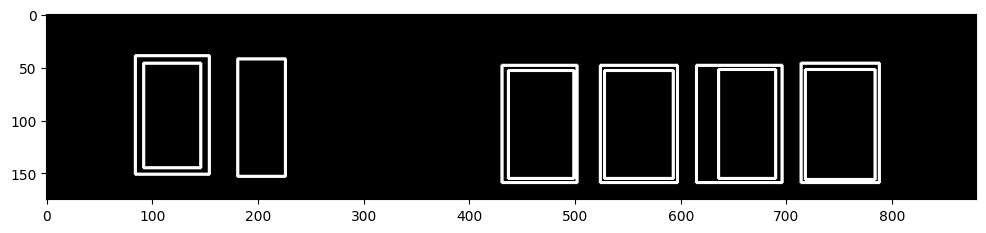

In [12]:
MAX_DIAG_MULTIPLYER = 5 # 5  대각선길이
MAX_ANGLE_DIFF = 12.0 # 12.0  1번째 contour와 2번째 contour 의 각도
MAX_AREA_DIFF = 0.5 # 0.5  면적의 차이
MAX_WIDTH_DIFF = 0.8 # 너비 차이
MAX_HEIGHT_DIFF = 0.2 # 높이 차이
MIN_N_MATCHED = 3 # 3 # 위에 조건들이 3개이상 충족해야 번호판이다

# find_chars 함수로 지정한다. 나중에 재귀함수로 반복해서 찾기 위함이다. idx값 저장

def find_chars(contour_list):
    matched_result_idx = []
    
    
# 이중for문으로 예를들면 첫번째 contour와 두번째 contour를 비교

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            
# np.linalg.norm(a - b) 벡터 a와 벡터 b 사이의 거리를 구한다.
# 삼각함수 사용
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) #면적의 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이의 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        # 번호판 후보군의 윤곽선 개수가 3보다 작으면 번호판일 확률이 낮다. 이유는 한국 번호판은 총 7자리 이기 때문이다.
        matched_contours_idx.append(d1['idx'])
        # 육관선 개수가 3보다 작을때는 continue를 통해 제외
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
        # 최종 호부군에 넣어주기
        matched_result_idx.append(matched_contours_idx)
        # 아닌 것들을 다시 한번 비교하고 넣어준다.
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

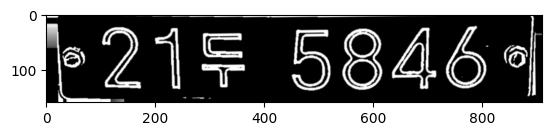

In [13]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
    # 센터 좌표 구하기
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    # 번호판의 기울어진 각도를 구하기 (삼각함수 이용)
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    # cv2.getRotationMatrix2D() 로테이션매트릭스를 구한다.
    # cv2.warpAffine() 이미지를 변현한다.
    # cv2.getRectSubPix() 회전된 이미지에서 원하는 부분만을 잘라낸다.
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

뉜21두5846꽤


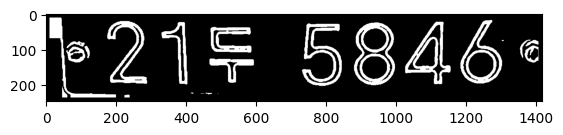

In [14]:
import pytesseract

longest_idx, longest_text = -1, 0
plate_chars = []
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    contours, _= cv2.findContours(plate_img,mode=cv2.RETR_LIST,method=cv2.CHAIN_APPROX_SIMPLE)
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

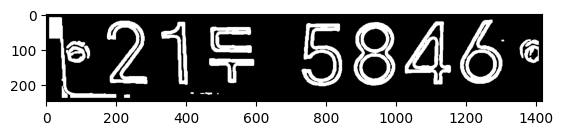

In [15]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dst = cv2.dilate(img_result, k)
plt.imshow(dst, cmap='gray')

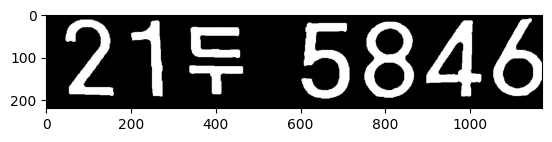

In [16]:
imgxx = cv2.imread(r'C:\DeepLearning\JupyterWorkspace\final_plate.jpg') 
plt.imshow(imgxx)

In [17]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
chars = pytesseract.image_to_string(imgxx, lang='kor', config='--psm 7 --oem 0')
    
result_chars = ''
has_digit = False
for c in chars:
    if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
        if c.isdigit():
            has_digit = True
        result_chars += c

print(result_chars)
plate_chars.append(result_chars)

if has_digit and len(result_chars) > longest_text:
    longest_idx = i

21두5846


In [18]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
chars = pytesseract.image_to_string(dst, lang='kor', config='--psm 7 --oem 0')
    
result_chars = ''
has_digit = False
for c in chars:
    if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
        if c.isdigit():
            has_digit = True
        result_chars += c

print(result_chars)
plate_chars.append(result_chars)

if has_digit and len(result_chars) > longest_text:
    longest_idx = i

1킨21두5846


In [23]:
import cv2
imgxx = cv2.imread('jj.jpg') 
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'
from paddleocr import PaddleOCR
ocr = PaddleOCR(lang="korean")
result = ocr.ocr(imgxx, cls=False)

ocr_result = result[0]
print(ocr_result)

[2024/04/15 18:09:23] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Lenovo/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Lenovo/.paddleocr/whl\\rec\\korean\\korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch